# ECG Split 1D-CNN Server Side
This code is the server part of ECG split 1D-CNN model for **single** client and a server.

## Import required packages

In [9]:
import os
import socket
import struct
import pickle
import time

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD

## Define ECG server model
Server side has **2 fully connected layers**.


In [10]:
class EcgServer(nn.Module):
    def __init__(self):
        super(EcgServer, self).__init__()
        self.linear4 = nn.Linear(32 * 16, 128)
        self.relu4 = nn.LeakyReLU() 
        self.linear5 = nn.Linear(128, 5)
        self.softmax5 = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.linear4(x)
        x = self.relu4(x)        
        x = self.linear5(x)
        x = self.softmax5(x)
        return x

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

### Set random seed

In [12]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Assign intial weight as same as non-split model

In [13]:
ecg_server = EcgServer()
ecg_server.to(device)

checkpoint = torch.load("init_weight.pth")
ecg_server.linear4.weight.data = checkpoint["linear4.weight"]
ecg_server.linear4.bias.data = checkpoint["linear4.bias"]
ecg_server.linear5.weight.data = checkpoint["linear5.weight"]
ecg_server.linear5.bias.data = checkpoint["linear5.bias"]

### Set other hyperparameters in the model
Hyperparameters here should be same with the client side.

In [14]:
batch_size = 32
total_batch = 414

epoch = 400
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = Adam(ecg_server.parameters(), lr=lr)

## Socket initialization
### Set host address and port number

### Required socket functions

In [15]:
def send_msg(sock, msg):
    # prefix each message with a 4-byte length in network byte order
    msg = struct.pack('>I', len(msg)) + msg
    sock.sendall(msg)

def recv_msg(sock):
    # read message length and unpack it into an integer
    raw_msglen = recvall(sock, 4)
    if not raw_msglen:
        return None
    msglen = struct.unpack('>I', raw_msglen)[0]
    # read the message data
    return recvall(sock, msglen)

def recvall(sock, n):
    # helper function to receive n bytes or return None if EOF is hit
    data = b''
    while len(data) < n:
        packet = sock.recv(n - len(data))
        if not packet:
            return None
        data += packet
    return data

In [16]:
host = 'localhost'
port = 10080
max_recv = 4096

### Open the server socket

In [17]:
s = socket.socket()
s.bind((host, port))
s.listen(5)

### Wait for Client

In [18]:
conn, addr = s.accept()
print('Conntected with', addr)

Conntected with ('127.0.0.1', 57639)


## Real training process

In [19]:
train_losses = list()
train_accs = list()
test_losses = list()
test_accs = list()
best_test_acc = 0  # best test accuracy

for e in range(epoch):
    print("Epoch {} - ".format(e+1), end='')
    
    train_loss = 0.0
    correct, total = 0, 0
    for i in range(total_batch):
        optimizer.zero_grad()  # initialize all gradients to zero
        msg = recv_msg(conn)  # receive client message from socket
        msg = pickle.loads(msg)  # deserialize
        client_output = msg['client_output']  # client output tensor
        label = msg['label']  # label
        client_output, label = client_output.to(device), label.to(device)
        output = ecg_server(client_output)  # forward propagation
        loss = criterion(output, label)  # calculates cross-entropy loss
        loss.backward()  # backward propagation
        client_grad = client_output.grad.clone().detach()
        msg = pickle.dumps(client_grad)
        send_msg(conn, msg)
        optimizer.step()
        
        train_loss += loss.item()
        correct += torch.sum(output.argmax(dim=1) == label).item()
        total += len(label)
    train_losses.append(train_loss / total_batch)
    train_accs.append(correct / total)
    train_status = "loss: {:.4f}, acc: {:.2f}% / ".format(train_losses[-1], train_accs[-1]*100)
    print(train_status, end='')
        
    with torch.no_grad():  # calculate test accuracy
        test_loss = 0.0
        correct, total = 0, 0
        for j in range(total_batch):
            msg = recv_msg(conn)
            msg = pickle.loads(msg)
            client_output = msg['client_output']
            test_label = msg['label']
            client_output, test_label = client_output.to(device), test_label.to(device)
            test_output = ecg_server(client_output)
            loss = criterion(test_output, test_label)
            
            test_loss += loss.item()
            correct += torch.sum(test_output.argmax(dim=1) == test_label).item()
            total += len(test_label)
        test_losses.append(test_loss / total_batch)
        test_accs.append(correct / total)
        test_status = "test_loss: {:.4f}, test_acc: {:.2f}%".format(test_losses[-1], test_accs[-1]*100)
        print(test_status)
        
    if test_accs[-1] > best_test_acc:
        best_test_acc = test_accs[-1]
    
    msg = pickle.dumps(train_status + test_status)
    send_msg(conn, msg)

Epoch 1 - loss: 1.3068, acc: 60.72% / test_loss: 1.1514, test_acc: 76.04%
Epoch 2 - loss: 1.1009, acc: 80.64% / test_loss: 1.0799, test_acc: 82.37%
Epoch 3 - loss: 1.0882, acc: 81.50% / test_loss: 1.0766, test_acc: 82.75%
Epoch 4 - loss: 1.0816, acc: 82.20% / test_loss: 1.0481, test_acc: 85.82%
Epoch 5 - loss: 1.0405, acc: 86.56% / test_loss: 1.0291, test_acc: 87.64%
Epoch 6 - loss: 1.0336, acc: 87.22% / test_loss: 1.0231, test_acc: 88.18%
Epoch 7 - loss: 1.0301, acc: 87.50% / test_loss: 1.0183, test_acc: 88.64%
Epoch 8 - loss: 1.0294, acc: 87.57% / test_loss: 1.0265, test_acc: 88.01%
Epoch 9 - loss: 1.0280, acc: 87.69% / test_loss: 1.0188, test_acc: 88.52%
Epoch 10 - loss: 1.0246, acc: 87.99% / test_loss: 1.0154, test_acc: 88.85%
Epoch 11 - loss: 1.0249, acc: 87.93% / test_loss: 1.0142, test_acc: 89.00%
Epoch 12 - loss: 1.0215, acc: 88.31% / test_loss: 1.0133, test_acc: 89.05%
Epoch 13 - loss: 1.0226, acc: 88.17% / test_loss: 1.0147, test_acc: 88.95%
Epoch 14 - loss: 1.0240, acc: 87.9

Epoch 110 - loss: 0.9689, acc: 93.24% / test_loss: 0.9706, test_acc: 93.05%
Epoch 111 - loss: 0.9696, acc: 93.18% / test_loss: 0.9711, test_acc: 93.00%
Epoch 112 - loss: 0.9668, acc: 93.46% / test_loss: 0.9712, test_acc: 92.97%
Epoch 113 - loss: 0.9666, acc: 93.47% / test_loss: 0.9724, test_acc: 92.91%
Epoch 114 - loss: 0.9679, acc: 93.34% / test_loss: 0.9708, test_acc: 93.05%
Epoch 115 - loss: 0.9670, acc: 93.39% / test_loss: 0.9722, test_acc: 92.87%
Epoch 116 - loss: 0.9691, acc: 93.20% / test_loss: 0.9726, test_acc: 92.84%
Epoch 117 - loss: 0.9682, acc: 93.33% / test_loss: 0.9715, test_acc: 92.95%
Epoch 118 - loss: 0.9663, acc: 93.48% / test_loss: 0.9726, test_acc: 92.83%
Epoch 119 - loss: 0.9671, acc: 93.40% / test_loss: 0.9713, test_acc: 92.97%
Epoch 120 - loss: 0.9660, acc: 93.55% / test_loss: 0.9846, test_acc: 91.63%
Epoch 121 - loss: 0.9689, acc: 93.23% / test_loss: 0.9738, test_acc: 92.74%
Epoch 122 - loss: 0.9694, acc: 93.20% / test_loss: 0.9748, test_acc: 92.67%
Epoch 123 - 

Epoch 218 - loss: 0.9164, acc: 98.84% / test_loss: 0.9233, test_acc: 98.17%
Epoch 219 - loss: 0.9166, acc: 98.84% / test_loss: 0.9277, test_acc: 97.73%
Epoch 220 - loss: 0.9201, acc: 98.47% / test_loss: 0.9244, test_acc: 98.06%
Epoch 221 - loss: 0.9178, acc: 98.70% / test_loss: 0.9252, test_acc: 97.98%
Epoch 222 - loss: 0.9179, acc: 98.70% / test_loss: 0.9301, test_acc: 97.43%
Epoch 223 - loss: 0.9180, acc: 98.67% / test_loss: 0.9247, test_acc: 97.98%
Epoch 224 - loss: 0.9163, acc: 98.86% / test_loss: 0.9235, test_acc: 98.15%
Epoch 225 - loss: 0.9147, acc: 99.00% / test_loss: 0.9214, test_acc: 98.35%
Epoch 226 - loss: 0.9152, acc: 98.96% / test_loss: 0.9242, test_acc: 98.06%
Epoch 227 - loss: 0.9166, acc: 98.84% / test_loss: 0.9274, test_acc: 97.75%
Epoch 228 - loss: 0.9200, acc: 98.48% / test_loss: 0.9256, test_acc: 97.92%
Epoch 229 - loss: 0.9179, acc: 98.68% / test_loss: 0.9286, test_acc: 97.63%
Epoch 230 - loss: 0.9174, acc: 98.72% / test_loss: 0.9222, test_acc: 98.26%
Epoch 231 - 

Epoch 326 - loss: 0.9165, acc: 98.84% / test_loss: 0.9259, test_acc: 97.89%
Epoch 327 - loss: 0.9155, acc: 98.93% / test_loss: 0.9233, test_acc: 98.13%
Epoch 328 - loss: 0.9138, acc: 99.11% / test_loss: 0.9233, test_acc: 98.15%
Epoch 329 - loss: 0.9150, acc: 98.97% / test_loss: 0.9229, test_acc: 98.20%
Epoch 330 - loss: 0.9166, acc: 98.82% / test_loss: 0.9255, test_acc: 97.92%
Epoch 331 - loss: 0.9149, acc: 99.00% / test_loss: 0.9232, test_acc: 98.17%
Epoch 332 - loss: 0.9163, acc: 98.86% / test_loss: 0.9242, test_acc: 98.06%
Epoch 333 - loss: 0.9165, acc: 98.84% / test_loss: 0.9237, test_acc: 98.11%
Epoch 334 - loss: 0.9155, acc: 98.93% / test_loss: 0.9253, test_acc: 97.94%
Epoch 335 - loss: 0.9152, acc: 98.95% / test_loss: 0.9232, test_acc: 98.17%
Epoch 336 - loss: 0.9144, acc: 99.03% / test_loss: 0.9285, test_acc: 97.63%
Epoch 337 - loss: 0.9175, acc: 98.73% / test_loss: 0.9240, test_acc: 98.06%
Epoch 338 - loss: 0.9169, acc: 98.78% / test_loss: 0.9274, test_acc: 97.73%
Epoch 339 - 

In [20]:
best_test_acc_epoch = np.array(test_accs).argmax() + 1
print('Best test accuracy {:.2f}% in epoch {}.'.format(best_test_acc*100, best_test_acc_epoch))

Best test accuracy 98.36% in epoch 383.


In [21]:
df = pd.DataFrame({  # save model training process into csv file
        'loss': train_losses,
        'test_loss': test_losses,
        'acc': train_accs,
        'test_acc': test_accs
    })
df.to_csv(os.path.join('csv', 'loss_and_acc.csv'))

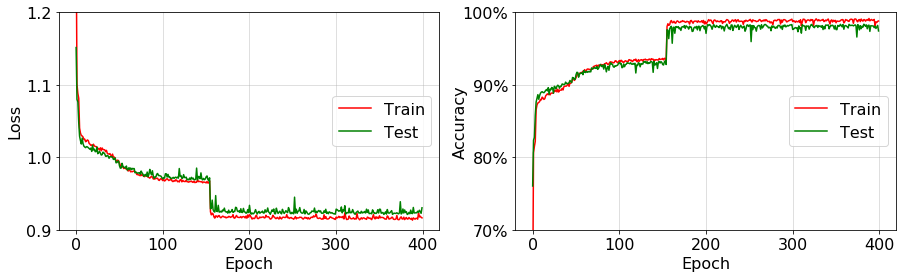

In [22]:
df = pd.read_csv(os.path.join('csv', 'loss_and_acc.csv'))
test_accs = df['test_acc']
train_accs = df['acc']
test_losses = df['test_loss']
train_losses = df['loss']

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(train_losses, color='red')
ax[0].plot(test_losses, color='green')
ax[0].set_xticks([0, 100, 200, 300, 400])
ax[0].set_xlabel('Epoch', size=16)
ax[0].set_ylabel('Loss', size=16)
ax[0].set_ylim(0.9, 1.1)
ax[0].set_yticks([0.9, 1.0, 1.1, 1.2])
ax[0].grid(alpha=0.5)
ax[0].tick_params(labelsize=16)
ax[0].legend(['Train', 'Test'], loc='right', fontsize=16)

ax[1].set_ylim(0.7, 1.0)
ax[1].set_yticks([0.7, 0.8, 0.9, 1.0])
ax[1].plot(train_accs, color='red')
ax[1].plot(test_accs, color='green')
yt = ax[1].get_yticks()
ax[1].set_yticklabels(['{:,.0%}'.format(x) for x in yt])
ax[1].set_xticks([0, 100, 200, 300, 400])
ax[1].set_xlabel('Epoch', size=16)
ax[1].set_ylabel('Accuracy', size=16, labelpad=-5)
ax[1].grid(alpha=0.5)
ax[1].tick_params(labelsize=16)
ax[1].legend(['Train', 'Test'], loc='right', fontsize=16)

fig.savefig('loss_acc_conv3_split_seed.pdf', bbox_inches='tight')